In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Numerical parameters
eps = 1e-12

## Global Parameters

In [69]:
# Non-dimensional parameters
# Damkohler numbers
Dam_tr = 1.0
Dam_ci = 1.4

# Peclet numbers
Pen_tr = 10.0
Pen_ci = 15.0

# Biot numbers
Bit_tr = 1.0e3
Bit_ci = 3.33

# Marangoni numbers
Man = 1.03

# Switching rate
k_tr = 1.0
k_ci = 30 * k_tr

chi_tr = 30.0
chi_ci = 1.0

print(k_tr * chi_tr, k_ci * chi_ci)

assert k_tr * chi_tr == k_ci * chi_ci

30.0 30.0


In [70]:
# Other parameters
# Length of the cell
L = 1.0

## Leading Order

### Setting Additional Parameters

In [81]:
# Setup required parameters
alpha = Dam_ci / Dam_tr
eta = Pen_tr / Pen_ci
zeta = Pen_tr * Dam_tr + Pen_ci * Dam_ci
beta = Bit_tr / Bit_ci
xi = Pen_ci * Bit_tr
nu = Dam_tr / Bit_tr

### Apply Boundary Conditions

In [82]:
# Define matrices
U = np.array([
    [alpha, eta],
    [1, -1]
])

In [83]:
# Quadratic coefficients
a = (
    ((eta - 1) / np.sqrt(zeta)) * np.sinh(np.sqrt(zeta)) * np.cosh(np.sqrt(zeta))
    * (eta * (nu * (1 + alpha) * beta + 1) * k_tr - (nu * (1 + alpha) + 1) * k_ci)
)

b = (
    (1 + alpha) * np.cosh(np.sqrt(zeta))
    * (eta * (nu * (1 + alpha) * beta + 1) * k_tr - (nu * (1 + alpha) + 1) * k_ci)
    + ((eta - 1) / np.sqrt(zeta)) * np.sinh(np.sqrt(zeta))
    * (alpha * (nu * (1 + alpha) * beta + 1) * k_tr + (nu * (1 + alpha) + 1) * k_ci)
)

c = (1 + alpha) * (alpha * (nu * (1 + alpha) * beta + 1) * k_tr + (nu * (1 + alpha) + 1) * k_ci)

d = (
    ((eta - 1) / np.sqrt(zeta)) * np.sinh(np.sqrt(zeta))
    + (1 / (chi_tr * k_tr) - 1 / (2 * L)) * np.cosh(np.sqrt(zeta))
    * (eta * (nu * (1 + alpha) * beta + 1) * k_tr - (nu * (1 + alpha) + 1) * k_ci)
)

e = (
    (1 + alpha)
    + (1 / (chi_tr * k_tr) - 1 / (2 * L))
    * (alpha * (nu * (1 + alpha) * beta + 1) * k_tr + (nu * (1 + alpha) + 1) * k_ci)
)

f = -1 / (2 * L)

p = (
    chi_ci * k_ci * np.sqrt(zeta) * np.sinh(np.sqrt(zeta)) * np.cosh(np.sqrt(zeta))
    * (
        ((1 + alpha) / xi) * (k_tr * beta * eta - k_ci)
        + ((alpha + eta) / zeta) * (k_tr * eta - k_ci)
    )
)

q = (
    chi_ci * k_ci * np.sqrt(zeta) * np.sinh(np.sqrt(zeta))
    * (
        alpha * k_tr * (((1 + alpha) * beta) / xi + (alpha + eta) / zeta)
        + k_ci * ((1 + alpha) / xi + (alpha + eta) / zeta)
    )
)

r = (
    chi_ci * k_ci * np.sqrt(zeta) * np.sinh(np.sqrt(zeta))
    * ((1 + alpha * beta) / xi + (alpha + eta) / zeta)
    + np.cosh(np.sqrt(zeta)) * (eta * k_tr + alpha * k_ci)
)

s = alpha * (k_tr - k_ci)

In [84]:
# Solve for B_1
poly = np.poly1d([
    a * q**2 - b * p * q + c * p**2,
    2 * a * q * s - b * p * s - b * q * r + 2 * c * p * r + d * q**2 - e * p * q,
    a * s**2 - b * r * s + c * r**2 + 2 * d * q * s - e * p * s - e * q * r + f * q**2,
    d * s**2 - e * r * s + 2 * f * q * s,
    f * s**2
])
roots = poly.r
print(roots)

[ 1.22733777e+12  2.48794921e-03 -9.26361291e-04  5.82728235e-04]


In [86]:
# Select a root
B_1 = roots[2]

In [87]:
# Solve for B_0
B_0 = -(p * B_1**2 + r * B_1) / (q * B_1 + s)

### Solutions to Leading Order

In [89]:
# Bulk concentrations
def w(y):
    return np.array([B_0, B_1 * np.cosh(y * np.sqrt(zeta))])

def c_0(y):
    return U @ w(y)

def c_tr_0(y):
    return alpha * B_0 + eta * B_1 * np.cosh(y * np.sqrt(zeta))

def c_ci_0(y):
    return B_0 - B_1 * np.cosh(y * np.sqrt(zeta))

# Surface concentrations
Delta = nu * (1 + alpha) * (beta * k_tr * c_tr_0(1) + k_ci * c_ci_0(1)) + k_tr * c_tr_0(1) + k_ci * c_ci_0(1) + 1

gamma_0 = (
    (1 / Delta) * (nu * (beta * k_tr * c_tr_0(1) + k_ci * c_ci_0(1)) * np.array([alpha, 1])
    + np.array([k_tr * c_tr_0(1), k_ci * c_ci_0(1)]))
)

gamma_tr_0 = (nu * (beta * k_tr * c_tr_0(1) + k_ci * c_ci_0(1)) * alpha + k_tr * c_tr_0(1)) / Delta

gamma_ci_0 = (nu * (beta * k_tr * c_tr_0(1) + k_ci * c_ci_0(1)) + k_ci * c_ci_0(1)) / Delta

assert abs(gamma_tr_0 - gamma_0[0]) < eps
assert abs(gamma_ci_0 - gamma_0[1]) < eps

assert abs((gamma_tr_0 + gamma_ci_0) - (1 - 1 / Delta)) < eps

9.409000604407067 15.459152702576988


### Solution Plots to Leading Order

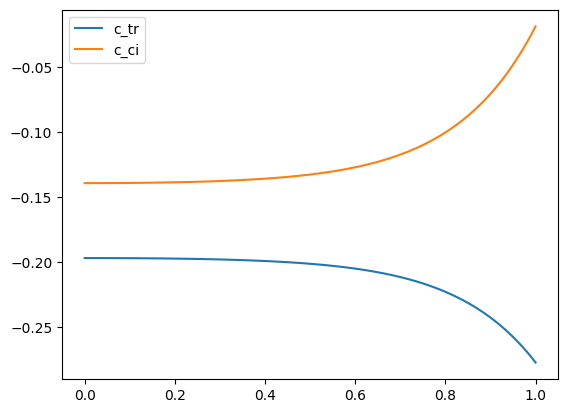

In [90]:
yy = np.linspace(0, 1, 100)

plt.plot(yy, c_tr_0(yy), label="c_tr")
plt.plot(yy, c_ci_0(yy), label="c_ci")
plt.legend()
plt.show()

## First Order

### Apply Boundary Conditions

In [ ]:
# Define matrices
A_s = np.array([
    [Pen_tr_s * Dam_tr, -Pen_tr_s * Dam_ci],
    [-Pen_ci_s * Dam_tr, Pen_ci_s * Dam_ci]
])

P_s = np.array([
    [Pen_tr_s, 0],
    [0, Pen_ci_s]
])

B = np.array([
    [Bit_tr, 0],
    [0, Bit_ci]
])

K = np.array([
    [k_tr, 0],
    [0, k_ci]
])

M = A_s + P_s @ B @ np.array([
    [k_tr * c_tr_0(1) + 1, k_tr * c_tr_0(1)],
    [k_ci * c_ci_0(1), k_ci * c_ci_0(1) + 1]
])

I = np.eye(2)

In [ ]:
# Define coefficients for bulk concentration
def a_p(omega):
    return (1 / (2 * omega * np.sqrt(zeta) + zeta)) * A_h(omega)

def b_p(omega):
    return (
        (1 / (2 * omega * np.sqrt(zeta) + zeta)**2)
        * (
            (2 * omega * np.sqrt(zeta) + zeta) * B_h(omega)
            - 2 * (omega + np.sqrt(zeta)) * A_h(omega)
        )
    )

def c_p(omega):
    return (1 / (2 * omega * np.sqrt(zeta) - zeta)) * A_h(omega)

def d_p(omega):
    return (
        (1 / (2 * omega * np.sqrt(zeta) - zeta)**2)
        * (
            (2 * omega * np.sqrt(zeta) - zeta) * B_h(omega)
            + 2 * (omega - np.sqrt(zeta)) * A_h(omega)
        )
    )

def e_p(omega):
    return (
        (1 / (2 * omega * np.sqrt(zeta) - zeta))
        * (A_h(omega) + 2 * omega * B_h(omega))
    )

def f_p(omega):
    return (
        (1 / (2 * omega * np.sqrt(zeta) - zeta)**2)
        * (
            (2 * omega * np.sqrt(zeta) - zeta) * B_h(omega)
            - 2 * (omega - np.sqrt(zeta)) * (A_h(omega) + 2 * omega * B_h(omega))
        )
    )

def g_p(omega):
    return (
        (1 / (2 * omega * np.sqrt(zeta) + zeta))
        * (A_h(omega) + 2 * omega * B_h(omega))
    )

def h_p(omega):
    return (
        (1 / (2 * omega * np.sqrt(zeta) + zeta)**2)
        * (
            (2 * omega * np.sqrt(zeta) + zeta) * B_h(omega)
            + 2 * (omega + np.sqrt(zeta)) * (A_h(omega) + 2 * omega * B_h(omega))
        )
    )

In [ ]:
# Constants of Integration
def A_h(omega):
    return (
        -(c_9 / a_9) * (1 - 4 * (np.sinh(2 * omega) - omega * np.exp(-2 * omega)) / (
            1.j * a_9 * (1 - Man * np.log(Delta)) * (np.sinh(omega) - omega * np.exp(-omega))
            + 4 * (np.sinh(2 * omega) - omega * np.exp(-2 * omega))
        ))
    )

def B_h(omega):
    return (A_h(omega) * np.sinh(omega)) / (np.sinh(omega) - omega * np.exp(-omega))

def E_h(omega):
    return (
        ((1.j * omega * np.sqrt(zeta) * B_1 * Pen_ci) / (2 * (alpha + eta)))
        * (
            a_p(omega) + c_p(omega) + e_p(omega) + g_p(omega)
            + (omega + np.sqrt(zeta)) * (b_p(omega) - h_p(omega))
            + (omega - np.sqrt(zeta)) * (d_p(omega) - f_p(omega))
        ) * ((eta * (eta - 1)) / omega)
    )

def G_h(omega):
    return (
        ((1.j * omega * np.sqrt(zeta) * B_1 * Pen_ci) / (2 * (alpha + eta)))
        * (
            a_p(omega) + c_p(omega) + e_p(omega) + g_p(omega)
            + (omega + np.sqrt(zeta)) * (b_p(omega) - h_p(omega))
            + (omega - np.sqrt(zeta)) * (d_p(omega) - f_p(omega))
        ) * ((alpha + eta**2) / np.sqrt(zeta + omega**2))
    )

### Solutions to First Order in Phase-Space

In [ ]:
# Streamfunction
def psi_h(omega, y):
    return (
        2 * (A_h * y + B_h) * np.sinh(omega * y)
        - 2 * B_h * omega * y * np.exp(-omega * y)
    )

# Bulk concentration
def p_h(omega, y):
    return (
        np.array([
            E_h(omega) * np.sinh(omega * y) + F_h(omega) * np.cosh(omega * y),
            G_h(omega) * np.sinh(np.sqrt(zeta + omega**2) * y) + H_h(omega) * np.cosh(np.sqrt(zeta + omega**2) * y)
        ])
        + f_h * np.array(
            -B_0,
            -B_1 * (1 + zeta / omega**2) * np.cosh(np.sqrt(zeta) * y)
        )
        -((1.j * omega * np.sqrt(zeta) * B_1 * Pen_ci) / (2 * (alpha + eta))) * np.array(
            eta * (eta - 1), alpha + eta**2
        ) * (
            ()
        )
    )

# Surface excess
def gamma_1(omega):
    return (
        -np.linalg.inv(M + omega**2 * I) @ (
            f_h * A_s + 1.j * omega * d_psi_h(omega, 1) * P_s
        ) @ gamma_0
        + (1 / Delta) * np.linalg.inv(M + omega**2 * I) @ P_s @ B @ K @ U @ (
            p_h + S_h * d_w(1)
        )
    )